# Basic Usage

This notebook will provide users with a broad overview of `opticam_new`'s features by reducing some synthetic data. For more detail about each aspect of `opticam_new`, see the dedicated tutorials.

## Generating Synthetic Data

First things first, let's generate some data:

In [1]:
from opticam_new.generate import create_synthetic_observations, create_synthetic_flats

create_synthetic_observations(out_dir='basic_usage_tutorial/data')  # generate some synthetic observations
create_synthetic_flats(out_dir='basic_usage_tutorial/flats')  # generate some synthetic flat-field images

Creating synthetic observations: 100%|██████████|[00:05<00:00]
Creating synthetic flats: 100%|██████████|[00:00<00:00]


These synthetic data come in three filters: $g$, $r$, and $i$, and are used in many of the guided tutorials.

## Defining a `Catalogue`

The first step in reducing OPTICAM data with `opticam_new` is to create a `Catalogue`. This does several things:
1. Applies a barycentric correction to the time stamp of each image.
2. Ensures there are no more than three unique filters used to capture the images in the specified directory. If more than three unique filters are found, an error will be raised with information on how to resolve the issue.
3. Ensures all the images in the specified directory use the same binning. If multiple binning values are detected, an error will be raised with information on how to resolve the issue.
4. Provides a visualisation of the image time stamps to check for gaps.

There are multiple ways to define a `Catalogue`, depending on how the images are stored on your system. If all the images are saved in a single directory, you can pass the path to this directory to the `data_directory` parameter. These images will then be separated by camera automatically. If, however, you already have images from separate cameras stored in separate directories, you may pass the path to the directory containing the images from camera 1 to `c1_directory`, and so on for cameras 2 and 3.

In addition to defining the input directory, `data_directory` (or `c1_directory`, etc.), it is also necessary to define an output directory, `out_directory`. This is the directory in which all the output files will be stored. If the specified directory does not exist, `Catalogue` will attempt to create it. We will also apply flat-field corrections by passing a `FlatFieldCorrector` (see the [corrections tutorial](applying_corrections.ipynb) for more details):

[OPTICAM] basic_usage_tutorial/reduced/ not found, attempting to create ...
[OPTICAM] basic_usage_tutorial/reduced/ created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 100 g-band images.
[OPTICAM] 100 r-band images.
[OPTICAM] 100 i-band images.


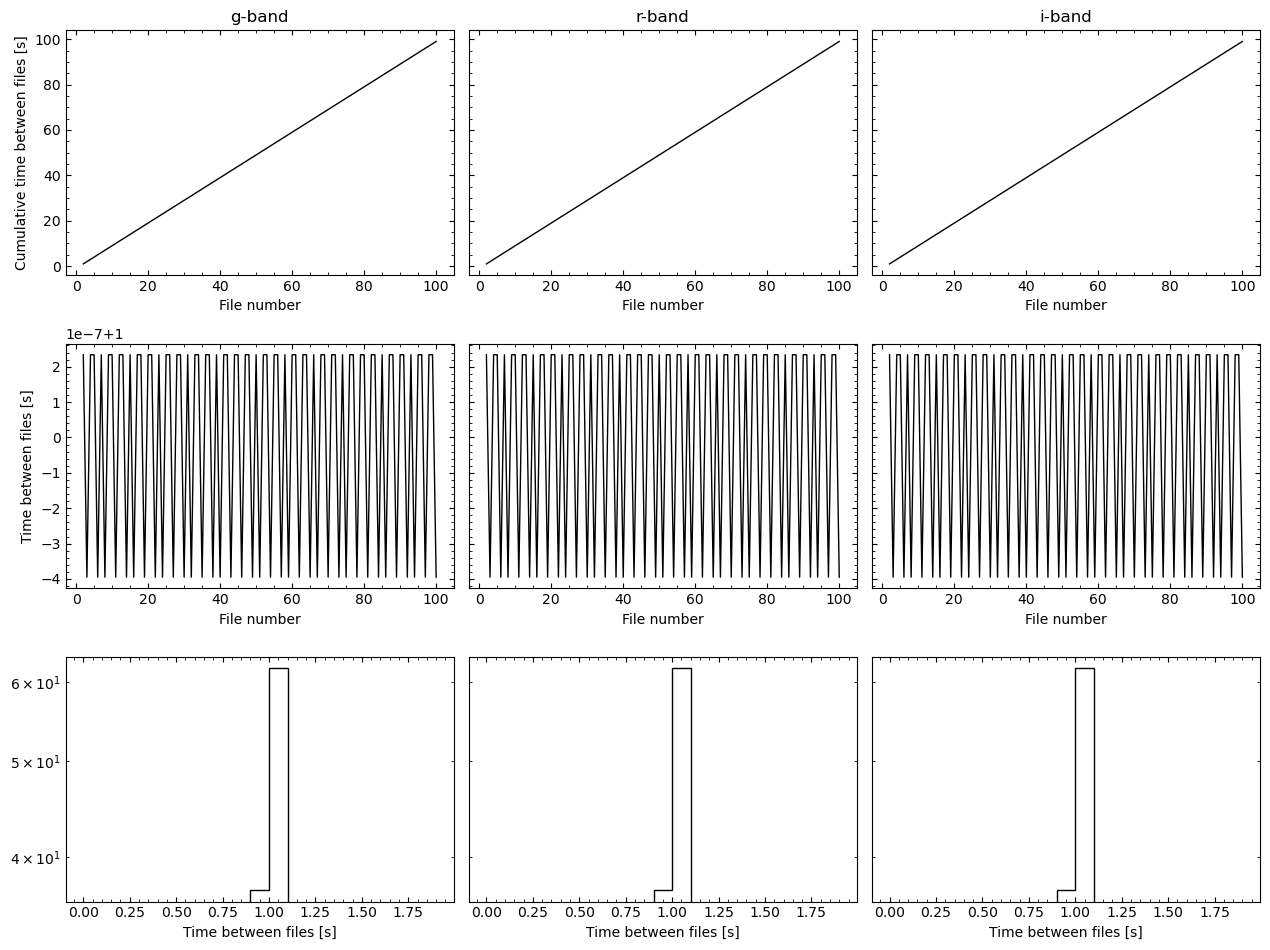

In [2]:
import opticam_new
from opticam_new.correctors import FlatFieldCorrector

cat = opticam_new.Catalogue(
    data_directory='basic_usage_tutorial/data/',  # path to the simulated data
    out_directory='basic_usage_tutorial/reduced/',  # path to where output will be saved
    flat_corrector=FlatFieldCorrector(out_dir='basic_usage_tutorial/master_flats', flats_dir='basic_usage_tutorial/flats'),  # flat field corrector
    remove_cosmic_rays=False,  # our simulated data do not contain cosmic rays
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    verbose=True,  # print out information about the catalogue creation (useful for diagnosis and debugging)
    )

After initialising a `Catalog` object, you will be presented with a lot of useful information about the data. As mentioned above, you may also be presented with some errors. In this case, no errors were raised and we can see our data do not contain any gaps, so we can proceed with reduction.

## Initialising the `Catalogue`

The next step is to create source catalogs for each camera. Initialising catalogs requires aligning each camera's images, and so this method is where the alignment parameters can be tweaked. Ideally, only small x, y translations should be needed. By default, images will be aligned `transform_type='translation'`, using the three brightest sources in the field as references. However, `euclidean` (translation and rotation) and `similarity` (translation, rotation, and scaling) are also available. The number of reference sources can also be changed, though 2 is the minimum for `euclidean` and `similarity`, and 1 is the minimum for `translation`. Try with 3 first, then tweak if needed.

To initialise the source catalogs, we can call the `initialise()` method:

[OPTICAM] Initialising catalogues ...
[OPTICAM] g-band master flat-field image not found. Attempting to create...
[OPTICAM] Master flat-field image created.


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


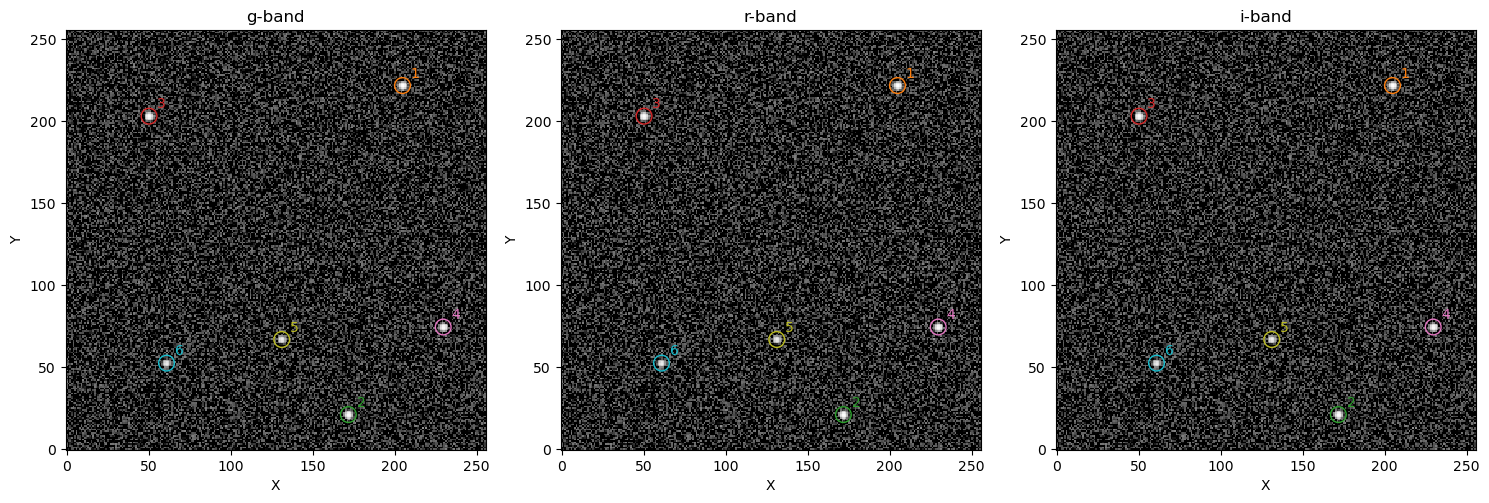

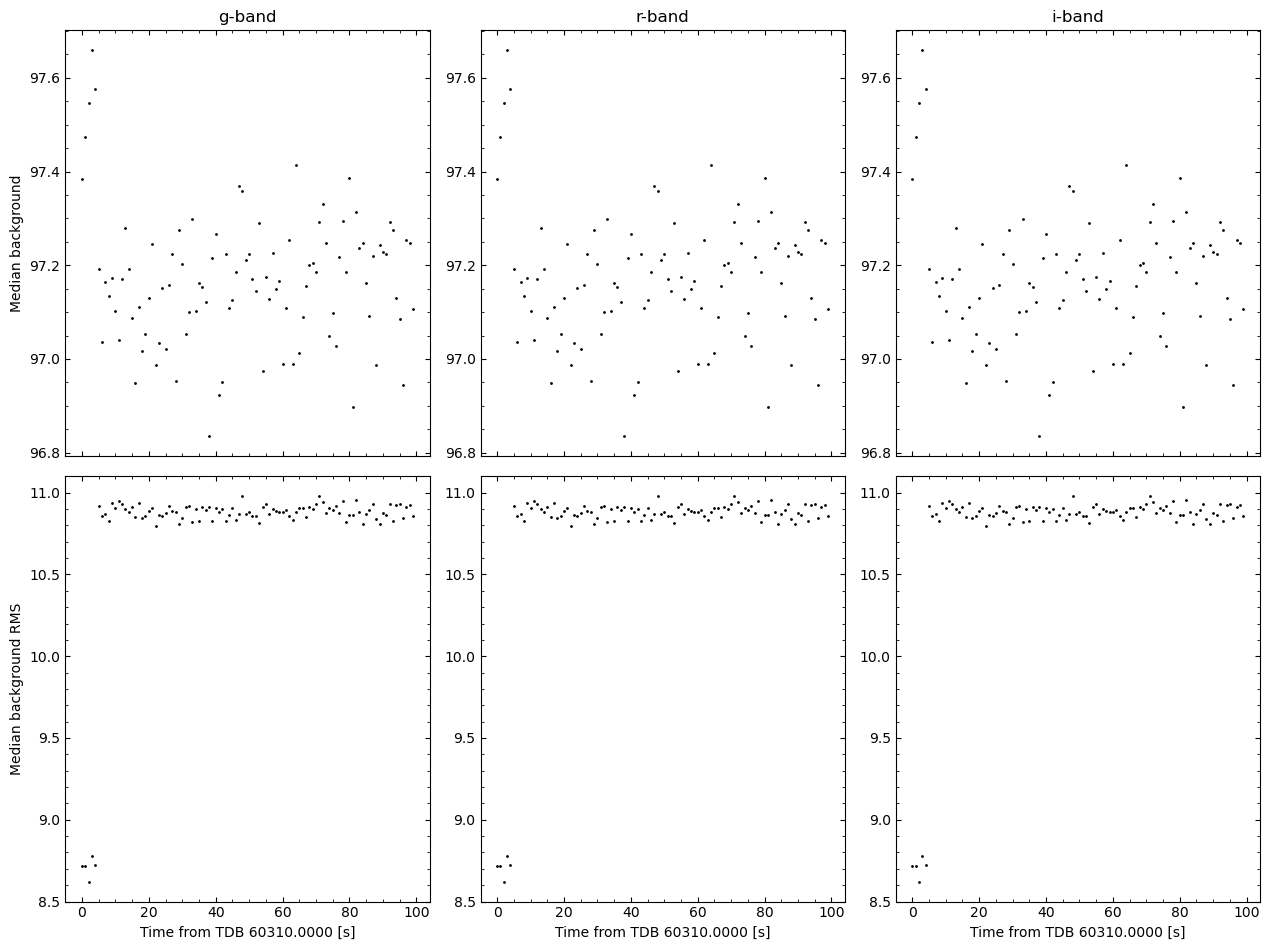

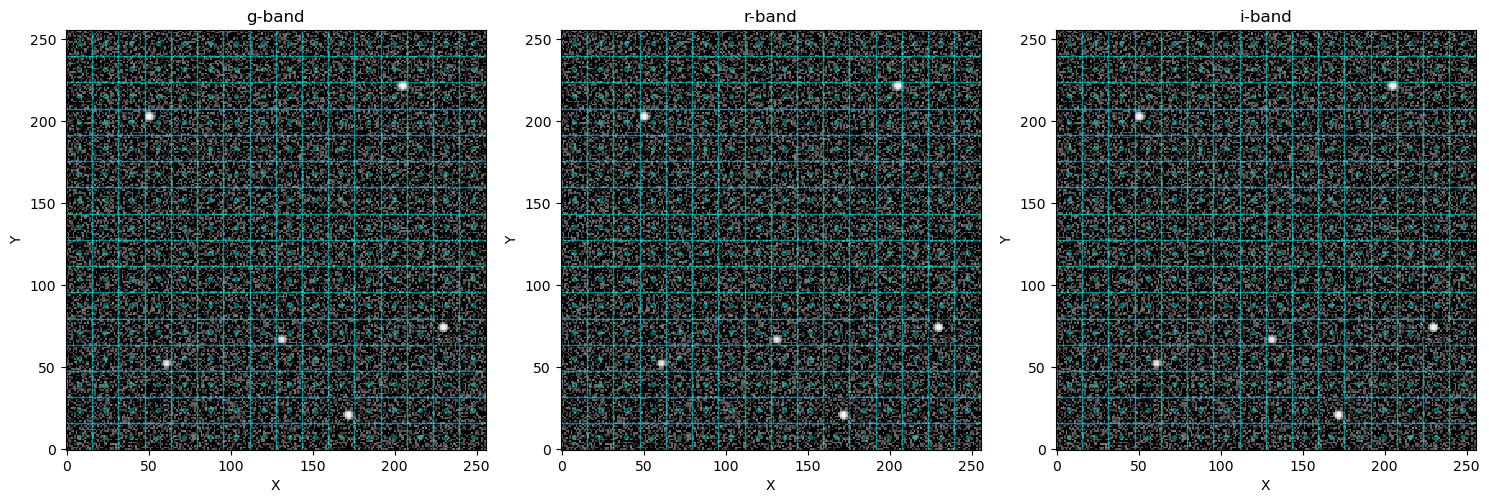

In [3]:
cat.initialise(overwrite=True, show_diagnostic_plots=True)

We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogs because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). After initialising our catalogs, a number of diagnostic plots are also generated. By default, these plots are not shown but are saved to the `out_directory/diag` directory. In this case, we passed `show_diagnosis_plots=True` and so we can see these plots:
1. The first diagnosis plot shows the average background as a function of time for each camera. This can be useful to check for structure in the average background.
2. The second diagnosis plot shows the 2D background mesh. This is useful to check how large the sources are relative to the 2D background "pixels". The background "pixels" should be larger than the typical source size, but small enough to capture background variations across the image.

## Performing Photometry

With our catalogs defined, we can now perform photometry. Performing photometry in `opticam_new` requires a photometer object that inherits from `opticam_new.photometers.BasePhotometer`. Currently, `opticam_new` provides two such objects: `SimplePhotometer`, for performing simple aperture photometry, and `OptimalPhotometer`, for performing optimal photometry (as described in [Naylor 1998, MNRAS, 296, 339-346](https://ui.adsabs.harvard.edu/abs/1998MNRAS.296..339N/abstract)). Both photometers can be customised to perform "forced photometry" for faint sources, and can use either the `Catalogue`'s 2D background estimator or estimate the local background around each source using an annulus. In this example, I'll show a couple of different photometry configurations:

In [4]:
from opticam_new.local_background import DefaultLocalBackground

# default simple photometer (not used but included for reference)
default_photometer = opticam_new.photometers.SimplePhotometer(
    # identify sources in each image and match them to the sources in the catalogue
    # (useful for refining source positions, but can miss faint sources or misidentify sources in crowded fields)
    match_sources=True,
    # source matching tolerance in standard deviations (assuming a 2D Gaussian PSF)
    source_matching_tolerance=2.,
    # method for estimating the background
    # 'global' uses the catalogue's 2D background estimator
    # 'local' uses the local_background_estimator 
    background_method='global',
    local_background_estimator=None,  # no local background estimator by default
)

# simple photometer with local background estimations and no source matching
default_annulus_photometer = opticam_new.photometers.SimplePhotometer(
    match_sources=False,  # do not match sources to the catalogue (forced photometry)
    source_matching_tolerance=2.,
    background_method='local',  # use local background estimation
    local_background_estimator=DefaultLocalBackground(),  # use the default local background estimator
)

# default optimal photometer
# implements the method described in Naylor 1998, MNRAS, 296, 339-346
optimal_photometer = opticam_new.photometers.OptimalPhotometer(
    match_sources=True,
    source_matching_tolerance=2.,
    background_method='global',
    local_background_estimator=None,
)

Once a photometer has been defined, it can be passed to the catalogue's `photometry()` method to compute the raw light curves:

In [5]:
cat.photometry(default_annulus_photometer)

[OPTICAM] Performing photometry for g-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving forced_simple_annulus photometry results for g-band sources: 100%|██████████| 6/6 [00:00<00:00, 1037.64it/s]
[OPTICAM] Performing photometry for r-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving forced_simple_annulus photometry results for r-band sources: 100%|██████████| 6/6 [00:00<00:00, 1101.69it/s]
[OPTICAM] Performing photometry for i-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving forced_simple_annulus photometry results for i-band sources: 100%|██████████| 6/6 [00:00<00:00, 1106.92it/s]


You may notice that the output above refers to the `default_annulus_photometer` results as `forced_simple_annulus photometry results`. The `forced` prefix refers to the fact that we specified `match_sources=False`, while the `annulus` suffix signifies that we specified `background_method='local'`. If we compare this to the output for `optimal_photometer`, you'll find that there is no prefix or suffix since we used the default parameter values of `match_sources=True` and `background_method='global'`:

In [6]:
cat.photometry(optimal_photometer)

[OPTICAM] Performing photometry for g-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal photometry results for g-band sources: 100%|██████████| 6/6 [00:00<00:00, 1322.85it/s]
[OPTICAM] Performing photometry for r-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal photometry results for r-band sources: 100%|██████████| 6/6 [00:00<00:00, 1343.68it/s]
[OPTICAM] Performing photometry for i-band: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving optimal photometry results for i-band sources: 100%|██████████| 6/6 [00:00<00:00, 1302.31it/s]


The name of the subdirectory to which the photometry results are saved also depends on the values of `match_sources` and `background_method`, as we'll see in a moment.

## Computing Relative Light Curves

We now have some raw light curves using a couple of different photometry configurations. However, raw light curves contain a lot of atmospheric and systematic variability, and so we often want to compute the relative light curve between our source of interest and some comparison sources to reduce this atmospheric/systematic variability.

In this example, we will assume that source 2 is our target of interest, and will use all other sources for comparisons. In practise, the choice of comparison star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD, since the systematics can vary with posiiton, as well as the source colour.

Let's now produce a relative light curve for source 2 using the 'forced_simple_annulus' light curves created by `default_annulus_photometer`. First, however, we need to initialise a `DifferentialPhotometer` object. When initialising a `DifferentialPhotometer` object, we need to pass the directory path to the reduced data created by `Catalog`:

[OPTICAM] Filters: g-band, r-band, i-band


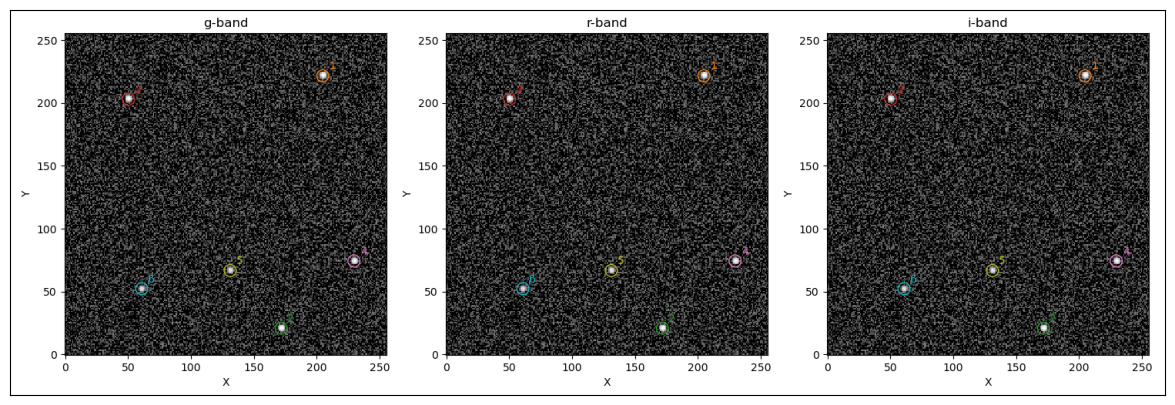

In [7]:
from opticam_new import DifferentialPhotometer

diff_phot = DifferentialPhotometer(
    out_directory='basic_usage_tutorial/reduced',  # same as the catalogue's out_directory
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    )

When initialising a `DifferentialPhotometer()` object, the source catalogs are output for convenience (unless `show_plots=False`). We can now create our relative light curve:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


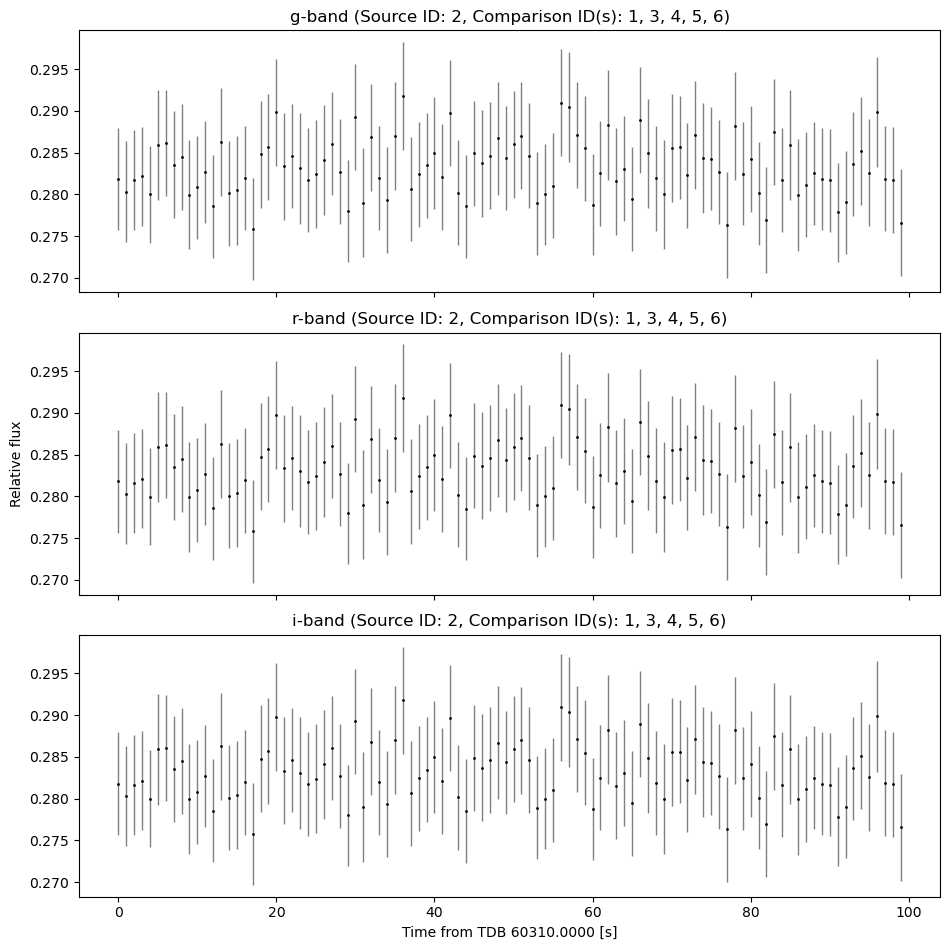

In [8]:
target = 2  # source of interest
comparisons = [1, 3, 4, 5, 6]  # comparison sources

analyser = diff_phot.get_relative_light_curve(
    'g-band',  # filter for which to compute the relative light curve
    target,  # source of interest
    comparisons,  # comparison sources
    phot_label='forced_simple_annulus',  # label for the photometry results
    prefix='test',  # prefix for the output files
    match_other_cameras=True,  # match sources across cameras (use with caution, does not always work well)
    show_diagnostics=False,  # show diagnostic plots (useful for diagnosis and debugging)
    )

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics` is set to `False`. For this example, I have set `show_diagnostics=False` for simplicity since we have several comparison sources and so a lot of plots will be generated.

The `get_relative_light_curve()` method can also match sources across filters by setting `match_other_cameras=True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified when `match_other_cameras=True`. In this case, we can see that the identified sources are correct, and so we don't have to manually create relative light curves for each filter.

When relative light curves are created, an `Analyser` object is returned. This analyser object can be used to perform a few basic timing analyses, such as computing periodograms and phase folding. In this case, we'll take a look at the periodograms for each camera and see if there's anything interesting there:

/home/zac/Documents/University/PhD/Repos/opticam_new/opticam_new/analyser.py:188: RuntimeWarning: divide by zero encountered in divide
  return 1 / x


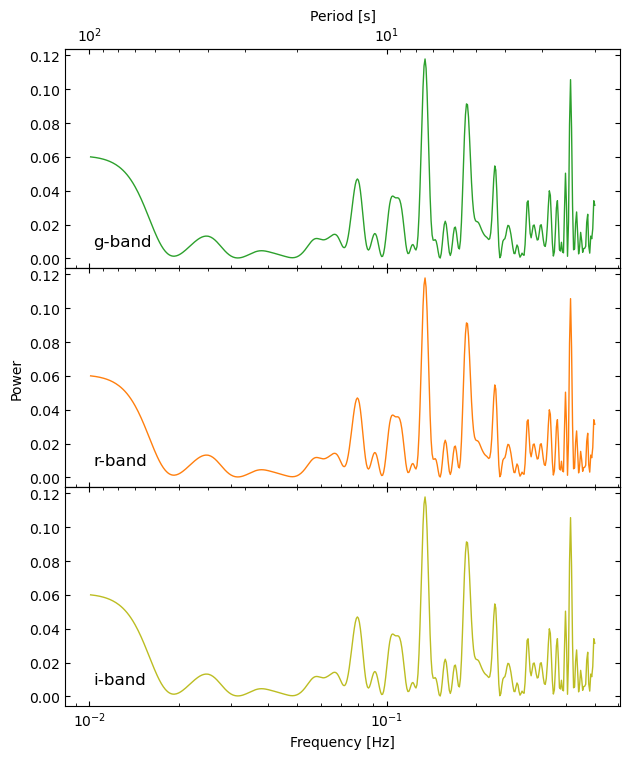

In [9]:
frequencies, periodograms = analyser.lomb_scargle(scale='log', show_plot=True)

As we can see, there are strong signals at $\sim$ 0.15 Hz, $\sim$ 0.2 Hz, and $\sim$ 0.4 Hz. Let's see if these periodograms change when we use the light curves produced by `optimal_photometer`:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


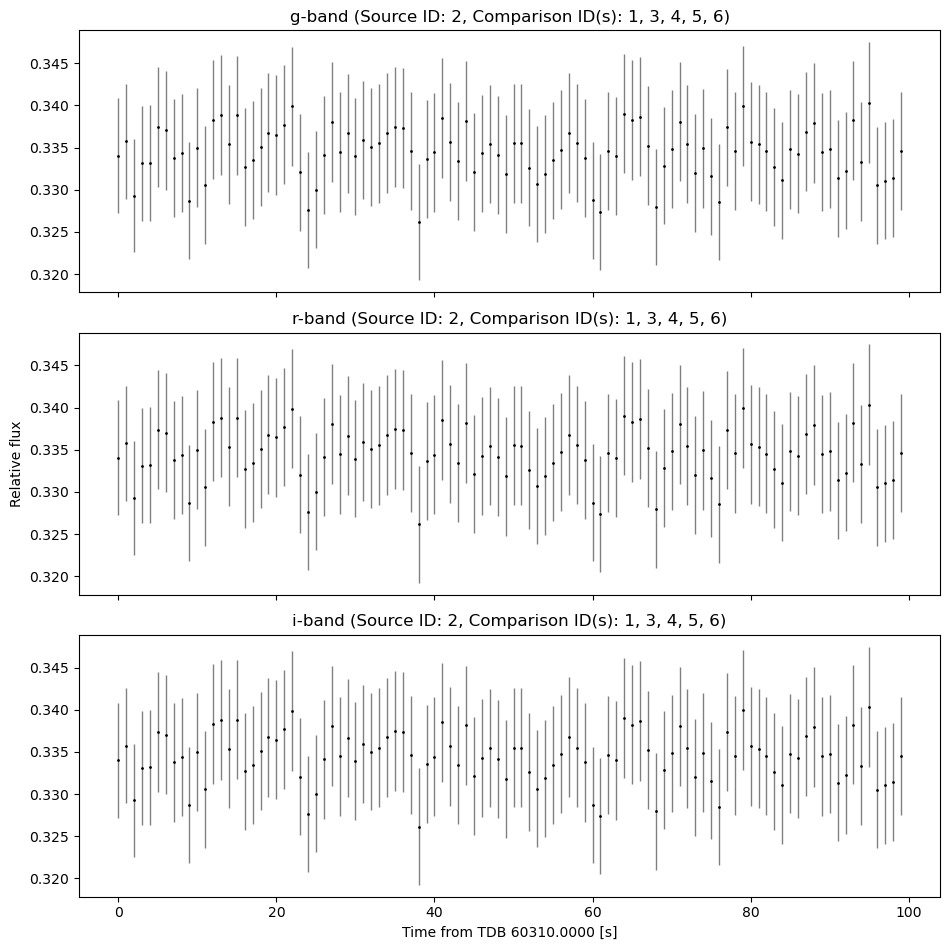

In [10]:
analyser = diff_phot.get_relative_light_curve('g-band', target, comparisons, phot_label='optimal', prefix='test',
                                              match_other_cameras=True, show_diagnostics=False)

/home/zac/Documents/University/PhD/Repos/opticam_new/opticam_new/analyser.py:188: RuntimeWarning: divide by zero encountered in divide
  return 1 / x


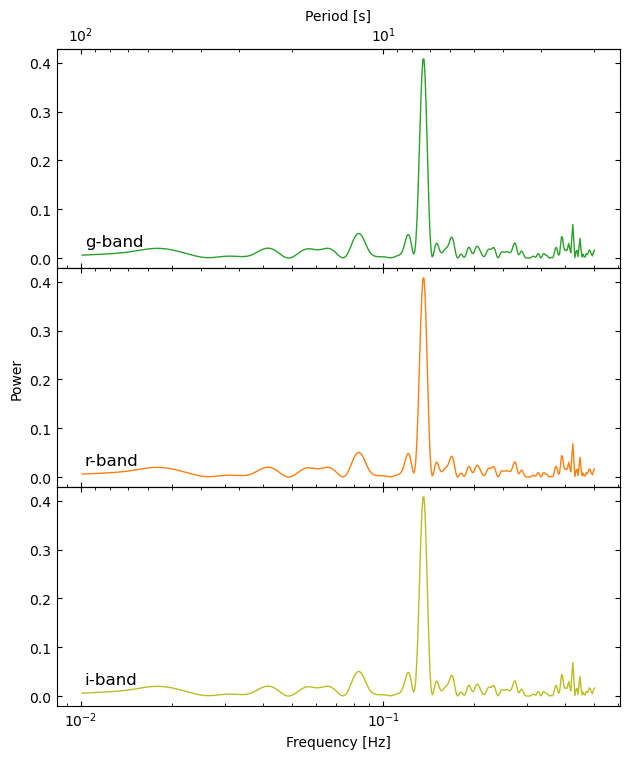

In [11]:
frequencies, powers = analyser.lomb_scargle(scale='log', show_plot=True)

Now the periodograms are dominated by the $\sim$ 0.15 Hz periodicity, and the noise peaks have been significantly reduced. Let's get the frequency of the tallest peak and use it to phase fold the light curves:

In [12]:
import numpy as np
import astropy.units as u

f = frequencies[np.argmax(powers['g-band'])] * u.Hz
f_res = frequencies[0] * u.Hz  # resolution of the periodogram

print(f'Peak frequency: {f.value:.3f} +/- {f_res.value:.3f} Hz')

Peak frequency: 0.135 +/- 0.010 Hz


So there appears to be a periodicity at $0.135 \pm 0.010$ Hz. This is a reassuring result, since the true periodicity of the signal is 0.135 Hz! Let's take a look at the phase folded light curve:

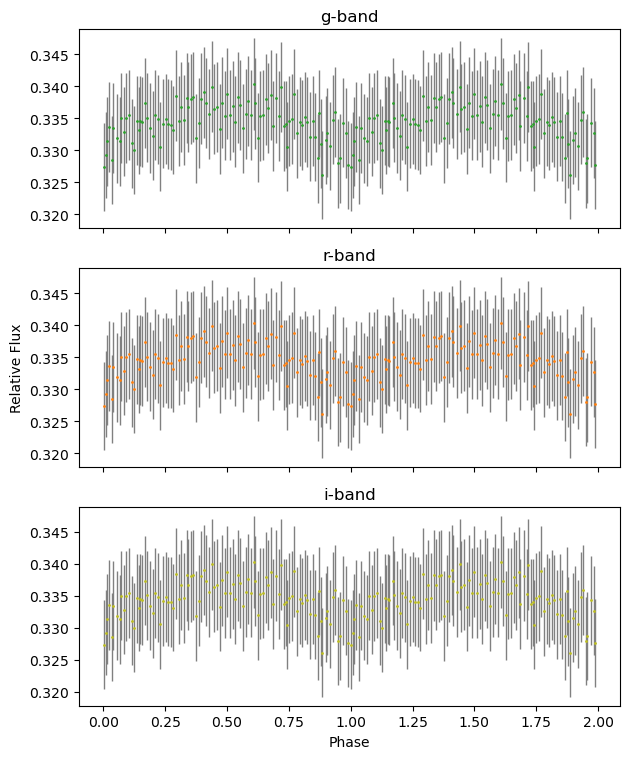

In [13]:
# NOTE: the period must be an astropy unit object (e.g. u.s, u.min, u.hour, u.day) to ensure the correct units are used
phases = analyser.phase_fold(period=1/f)

Now we can clearly see the pulse shape!

In addition to creating a plot, the `phase_fold` method also returns a dictionary of phase values for each band should you want to perform any further analysis.

In some cases, the phase folded light curves may not be especially revealing, and so we may want to get a clearer picture of the pulse shape by *phase binning*. Let's take a look at the phase binned light curve:

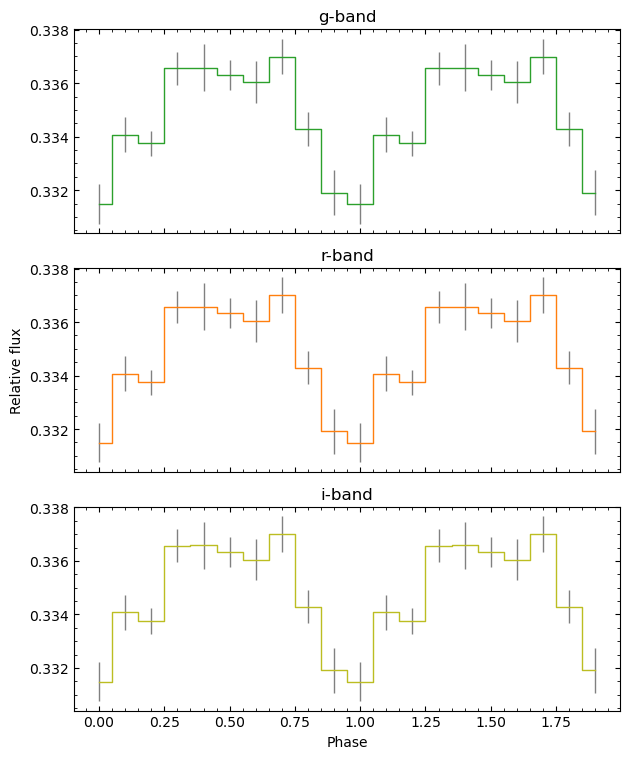

In [14]:
phase_bin_results = analyser.phase_bin(period=1/f)

Now the pulse shape is even clearer! In addition to the plot, we also get a dictionary of the phase binning results, should you want to use them in a further analysis.

That concludes the basic usage tutorial for `opticam_new`! For more specific documentation on each stage of the pipeline, see the dedicated tutorials.